In [1]:
import sys
!{sys.executable} -m pip install tqdm

You are using pip version 9.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm, tqdm_notebook
from scipy.stats import ks_2samp
%matplotlib inline

from sklearn import metrics
from sklearn import preprocessing, cross_validation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import keras
from keras.layers import Dense, Dropout, Input, LSTM, Activation
from keras.models import Model,Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Read Datasets 
research_data_raw = pd.read_csv('Datasets/bitcoin_research_data_v2.csv')

# Drop unnecessary columns
research_data = research_data_raw.drop('Unnamed: 0', axis=1)
research_data.head()

,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USD,Popularity,Popularity_Normalized
0,2019-05-11,BTCUSD,6337.9,6984.8,6337.9,6793.5,9855.87,66133073.75,12.0,1200.0
1,2019-05-10,BTCUSD,6151.4,6430.0,6110.1,6337.9,9872.86,62166515.28,12.0,1200.0
2,2019-05-09,BTCUSD,5939.6,6174.0,5933.2,6151.4,7405.18,44816872.39,12.0,1200.0
3,2019-05-08,BTCUSD,5744.0,5983.2,5660.0,5939.6,6007.11,35184697.52,12.0,1200.0
4,2019-05-07,BTCUSD,5687.4,5955.8,5687.4,5906.7,3668.12,21496575.65,12.0,1200.0


In [4]:
# Set Date column as index and drop other columns that won't be used by the model
research_data = research_data.set_index('Date')
research_data.index = pd.to_datetime(research_data.index)
research_data = research_data.sort_index()
research_data = research_data.drop(['Symbol','Popularity_Normalized','Volume BTC','Volume USD'], 1)
research_data.head()

,Open,High,Low,Close,Popularity
Date,,,,,
2014-05-18,453.83,453.83,445.56,445.56,2.0
2014-05-19,445.56,445.56,445.56,445.56,2.0
2014-05-20,445.56,498.84,445.56,493.43,2.0
2014-05-21,493.43,497.67,490.85,494.77,2.0
2014-05-22,494.77,530.00,494.77,530.00,2.0


In [5]:
# Get lenght of dataset
print(len(research_data))

1808


In [6]:
# Check for null values
research_data.isna().sum()

Open          0
High          0
Low           0
Close         0
Popularity    0
dtype: int64

In [7]:
# Define constants
TIME_STEPS = 10
TEST_SIZE = 0.1
EPOCHS = 400
BATCH_SIZE_NN = 4
GAN_TRAIN_BATCH_SIZE = 12
FEATURES = len(research_data.columns)

In [8]:
# Define train_test split function
def train_test_split(df, test_size):
    splitting_point = len(df) - int(test_size * len(df))
    train_data = df.iloc[:splitting_point]
    test_data = df.iloc[splitting_point:]
    return train_data, test_data

In [9]:
# Define plot function
def line_plot(line1, line2, label1=None, label2=None, title=''):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(line1, label=label1, linewidth=2)
    ax.plot(line2, label=label2, linewidth=2)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18)

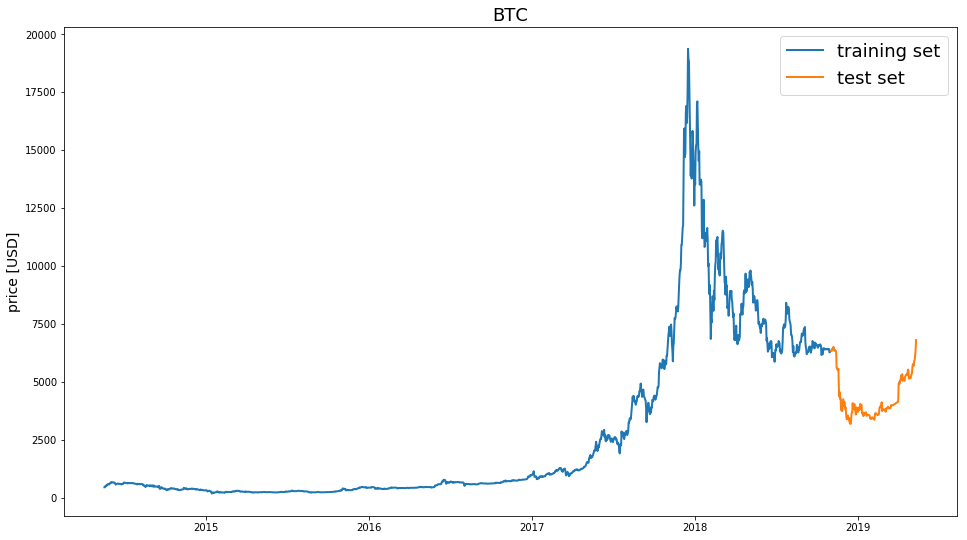

In [10]:
# Plot train and test sets
train, test = train_test_split(research_data, TEST_SIZE)
line_plot(train.Close, test.Close, 'training set', 'test set', 'BTC')

In [11]:
# Define function to normalize data with respect to first entry in the sequence. The first instance in the 
# sequence will always be zero (df / df.iloc[0] - 1) and all other instances will be relative to that first
# instance, representing the rate of change in the sequence
def get_rate_change_zero_base(df):
    return df / df.iloc[0] - 1

In [12]:
# Define function to convert dataframe into numpy array of sequences
def build_sequence(df, window_size):
    sequence_data = []
    for idx in range(len(df) - window_size):
        temp_data = df[idx: (idx + window_size)].copy()
        temp_data = get_rate_change_zero_base(temp_data)
        sequence_data.append(temp_data.values)
    return np.array(sequence_data)

In [13]:
# Define function to get training and test sets for GAN
def get_data(df, window_size, test_size):
    # train test split
    train_data, test_data = train_test_split(df, test_size)
    
    # extract sequence from data
    X_train = build_sequence(train_data, window_size)
    X_test = build_sequence(test_data, window_size)
    
    # extract targets
    y_train = train_data.Close[window_size:].values / train_data.Close[:-window_size].values - 1
    y_test = test_data.Close[window_size:].values / test_data.Close[:-window_size].values - 1
    
    return train_data, test_data, X_train, X_test, y_train, y_test

In [14]:
# Get the proper sets for GAN
train, test, X_train, X_test, y_train, y_test = get_data(research_data, TIME_STEPS, TEST_SIZE)

# Print set shapes
print('X_train shape: ' + str(X_train.shape))
print('y_train shape: ' + str(y_train.shape))
print('X_test shape: ' + str(X_test.shape))
print('y_test shape: ' + str(y_test.shape))

X_train shape: (1618, 10, 5)
y_train shape: (1618,)
X_test shape: (170, 10, 5)
y_test shape: (170,)


In [15]:
# Create Generator Model and get its summary
def create_generator():
    optimizer = RMSprop(lr=0.005, clipvalue=1.)
    
    generator = Sequential()
    generator.add(LSTM(16, batch_input_shape=(BATCH_SIZE_NN, TIME_STEPS, FEATURES), return_sequences=True))
    generator.add(LeakyReLU(0.05))
    generator.add(LSTM(32,return_sequences=True))
    generator.add(LeakyReLU(0.05))
    generator.add(Dropout(0.5))
    generator.add(LSTM(64,return_sequences=False))
    generator.add(Dense(FEATURES))
    generator.add(Activation('tanh'))
    
    generator.compile(loss='mean_squared_error', optimizer=optimizer)

    return generator

generator = create_generator()
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (4, 10, 16)               1408      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (4, 10, 16)               0         
_________________________________________________________________
lstm_2 (LSTM)                (4, 10, 32)               6272      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (4, 10, 32)               0         
_________________________________________________________________
dropout_1 (Dropout)          (4, 10, 32)               0         
_________________________________________________________________
lstm_3 (LSTM)                (4, 64)                   24832     
_________________________________________________________________
dense_1 (Dense)              (4, 5)                    325       
__________

In [16]:
# Create Discriminator Model and get its summary
def create_discriminator():
    optimizer = RMSprop(lr=0.0002, decay=6e-8)

    discriminator=Sequential()

    discriminator.add(Dense(units=32, batch_input_shape=(8, TIME_STEPS, FEATURES)))
    discriminator.add(LeakyReLU(0.01))
    discriminator.add(Dense(units=64))
    discriminator.add(LeakyReLU(0.01))
    discriminator.add(Dense(units=128))
    discriminator.add(LeakyReLU(0.01))
    discriminator.add(Dense(units=220,activation='linear'))
    discriminator.add(Activation('relu'))
    discriminator.add(Dense(1,activation='linear'))
    
    discriminator.compile(loss='mean_squared_error', optimizer=optimizer)
    
    return discriminator

discriminator = create_discriminator()
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (8, 10, 32)               192       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (8, 10, 32)               0         
_________________________________________________________________
dense_3 (Dense)              (8, 10, 64)               2112      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (8, 10, 64)               0         
_________________________________________________________________
dense_4 (Dense)              (8, 10, 128)              8320      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (8, 10, 128)              0         
_________________________________________________________________
dense_5 (Dense)              (8, 10, 220)              28380     
__________

In [17]:
# Create GAN with Generator and Discriminator and get its summary
def create_gan(discriminator, generator):
    optimizer = RMSprop(lr=0.0001, decay=3e-8) 
    discriminator.trainable=False
    
    gan_input = Input(shape=(TIME_STEPS, FEATURES))
    generated_data = generator(gan_input)
    gan_output= discriminator(generated_data)
    gan = Model(inputs=gan_input, outputs=gan_output)
    
    gan.compile(loss='mean_squared_error', optimizer=optimizer)
    
    return gan

gan = create_gan(discriminator, generator)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10, 5)             0         
_________________________________________________________________
sequential_1 (Sequential)    multiple                  32837     
_________________________________________________________________
sequential_2 (Sequential)    multiple                  39225     
Total params: 72,062
Trainable params: 32,837
Non-trainable params: 39,225
_________________________________________________________________


In [18]:
# Define values to be tracked during GAN training
gan_loss = []
discrimator_loss = []

In [19]:
# Define GAN training function
def train_gan(epochs, batch_size):
    # Make sure global variables are accessible within the training function
    global adversarial_loss
    global discrimator_loss
    
    global generator
    global discriminator
    global gan

    global X_train
    global X_test
    global y_train
    global y_test
    
    for e in range(1, epochs+1):
        print("Epoch %d" %e)
        for i in tqdm(range(batch_size)):
            # Generate noise data - with same shape as the traning data
            noise = np.float32(np.random.normal(size=[BATCH_SIZE_NN, TIME_STEPS, FEATURES]))
            
            # Generate fake prices from noise data
            generated_prices = generator.predict(noise) # Shape = (4,5)
            
            # Get a random set of real prices
            prices_batch = X_train[np.random.randint(low=0, high=X_train.shape[0], size=BATCH_SIZE_NN)]
            
            # Get generated prices to have the same shape as the training data
            generated_prices_dim = generated_prices.shape[0]
            gen_prices = np.zeros((generated_prices_dim, TIME_STEPS, FEATURES)) # Shape = (4,10,5)
            for j in range(generated_prices_dim):
                gen_prices[j] = generated_prices[j]
            
            # Construct batch with real and fake data 
            X_dis = np.concatenate([prices_batch, gen_prices])
            X_dis_dim = X_dis.shape[0]
            
            # Construct labels batch for generated and real data
            y_dis = np.zeros(shape=(X_dis_dim, TIME_STEPS, 1))
            y_dis[:int((X_dis_dim/2))] = 0.9 # label 0.9 is assigned to real data
            
            # Pre train discriminator on fake and real data before starting the gan. 
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X_dis, y_dis)
            
            # Tricking the noised input of the Generator as real data
            noise = np.float32(np.random.normal(size=[BATCH_SIZE_NN, TIME_STEPS, FEATURES]))
            y_gen = np.ones(BATCH_SIZE_NN)
            
            # During the training of gan, the weights of discriminator should be fixed. 
            discriminator.trainable=False
            
            # Training the GAN by alternating the training of the Discriminator 
            # and training the chained GAN model with Discriminator’s weights freezed.
            g_loss = gan.train_on_batch(noise, y_gen)
            
            discrimator_loss.append(d_loss)
            gan_loss.append(g_loss)
            
            if i == (batch_size-1):
                log_mesg = "%d: [Discriminator loss: %f]" % (e, d_loss)
                log_mesg = "%s  [GAN loss: %f]" % (log_mesg, g_loss)
                print(log_mesg)
                

In [20]:
# Train GAN
train_gan(EPOCHS, GAN_TRAIN_BATCH_SIZE)

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1


 33%|███▎      | 4/12 [00:00<00:00, 36.08it/s]

1: [Discriminator loss: 0.318549]  [GAN loss: 0.818206]
Epoch 2


 33%|███▎      | 4/12 [00:00<00:00, 36.53it/s]

2: [Discriminator loss: 0.214489]  [GAN loss: 0.639312]
Epoch 3


 33%|███▎      | 4/12 [00:00<00:00, 37.20it/s]

3: [Discriminator loss: 0.214626]  [GAN loss: 0.479029]
Epoch 4


 33%|███▎      | 4/12 [00:00<00:00, 38.84it/s]

4: [Discriminator loss: 0.160408]  [GAN loss: 0.410786]
Epoch 5


 17%|█▋        | 2/12 [00:00<00:00, 12.20it/s]

5: [Discriminator loss: 0.136037]  [GAN loss: 0.406530]
Epoch 6


 33%|███▎      | 4/12 [00:00<00:00, 31.34it/s]

6: [Discriminator loss: 0.135077]  [GAN loss: 0.424099]
Epoch 7


 33%|███▎      | 4/12 [00:00<00:00, 32.86it/s]

7: [Discriminator loss: 0.122452]  [GAN loss: 0.459691]
Epoch 8


 17%|█▋        | 2/12 [00:00<00:00, 16.51it/s]

8: [Discriminator loss: 0.117100]  [GAN loss: 0.439328]
Epoch 9


 33%|███▎      | 4/12 [00:00<00:00, 35.79it/s]

9: [Discriminator loss: 0.094566]  [GAN loss: 0.511959]
Epoch 10


 33%|███▎      | 4/12 [00:00<00:00, 30.72it/s]

10: [Discriminator loss: 0.109527]  [GAN loss: 0.471248]
Epoch 11


 17%|█▋        | 2/12 [00:00<00:00, 18.21it/s]

11: [Discriminator loss: 0.092832]  [GAN loss: 0.578506]
Epoch 12


 33%|███▎      | 4/12 [00:00<00:00, 36.89it/s]

12: [Discriminator loss: 0.139607]  [GAN loss: 0.455934]
Epoch 13


 25%|██▌       | 3/12 [00:00<00:00, 29.72it/s]

13: [Discriminator loss: 0.172310]  [GAN loss: 0.465661]
Epoch 14


 33%|███▎      | 4/12 [00:00<00:00, 32.60it/s]

14: [Discriminator loss: 0.137190]  [GAN loss: 0.501882]
Epoch 15


 33%|███▎      | 4/12 [00:00<00:00, 35.64it/s]

15: [Discriminator loss: 0.216016]  [GAN loss: 0.412715]
Epoch 16


 33%|███▎      | 4/12 [00:00<00:00, 38.70it/s]

16: [Discriminator loss: 0.168966]  [GAN loss: 0.398902]
Epoch 17


 33%|███▎      | 4/12 [00:00<00:00, 34.03it/s]

17: [Discriminator loss: 0.150306]  [GAN loss: 0.361298]
Epoch 18


 33%|███▎      | 4/12 [00:00<00:00, 35.94it/s]

18: [Discriminator loss: 0.162051]  [GAN loss: 0.407736]
Epoch 19


 33%|███▎      | 4/12 [00:00<00:00, 39.58it/s]

19: [Discriminator loss: 0.181614]  [GAN loss: 0.476631]
Epoch 20


 42%|████▏     | 5/12 [00:00<00:00, 43.36it/s]

20: [Discriminator loss: 0.139303]  [GAN loss: 0.447546]
Epoch 21


 42%|████▏     | 5/12 [00:00<00:00, 41.82it/s]

21: [Discriminator loss: 0.156823]  [GAN loss: 0.426960]
Epoch 22


 33%|███▎      | 4/12 [00:00<00:00, 38.10it/s]

22: [Discriminator loss: 0.121697]  [GAN loss: 0.449180]
Epoch 23


 33%|███▎      | 4/12 [00:00<00:00, 39.96it/s]

23: [Discriminator loss: 0.123664]  [GAN loss: 0.454670]
Epoch 24


 33%|███▎      | 4/12 [00:00<00:00, 39.75it/s]

24: [Discriminator loss: 0.144375]  [GAN loss: 0.454435]
Epoch 25


 25%|██▌       | 3/12 [00:00<00:00, 21.06it/s]

25: [Discriminator loss: 0.100411]  [GAN loss: 0.530064]
Epoch 26


 33%|███▎      | 4/12 [00:00<00:00, 28.83it/s]

26: [Discriminator loss: 0.152793]  [GAN loss: 0.429409]
Epoch 27


 42%|████▏     | 5/12 [00:00<00:00, 41.68it/s]

27: [Discriminator loss: 0.113653]  [GAN loss: 0.452161]
Epoch 28


 42%|████▏     | 5/12 [00:00<00:00, 42.46it/s]

28: [Discriminator loss: 0.132404]  [GAN loss: 0.534005]
Epoch 29


 33%|███▎      | 4/12 [00:00<00:00, 37.23it/s]

29: [Discriminator loss: 0.120474]  [GAN loss: 0.477732]
Epoch 30


 42%|████▏     | 5/12 [00:00<00:00, 43.86it/s]

30: [Discriminator loss: 0.158315]  [GAN loss: 0.430157]
Epoch 31


 42%|████▏     | 5/12 [00:00<00:00, 42.42it/s]

31: [Discriminator loss: 0.133615]  [GAN loss: 0.459055]
Epoch 32


 33%|███▎      | 4/12 [00:00<00:00, 39.74it/s]

32: [Discriminator loss: 0.141385]  [GAN loss: 0.486147]
Epoch 33


 33%|███▎      | 4/12 [00:00<00:00, 39.38it/s]

33: [Discriminator loss: 0.173832]  [GAN loss: 0.511121]
Epoch 34


 33%|███▎      | 4/12 [00:00<00:00, 39.27it/s]

34: [Discriminator loss: 0.155188]  [GAN loss: 0.488624]
Epoch 35


 42%|████▏     | 5/12 [00:00<00:00, 42.02it/s]

35: [Discriminator loss: 0.151352]  [GAN loss: 0.406220]
Epoch 36


 33%|███▎      | 4/12 [00:00<00:00, 37.54it/s]

36: [Discriminator loss: 0.127247]  [GAN loss: 0.473651]
Epoch 37


 33%|███▎      | 4/12 [00:00<00:00, 38.65it/s]

37: [Discriminator loss: 0.104494]  [GAN loss: 0.409945]
Epoch 38


 42%|████▏     | 5/12 [00:00<00:00, 42.03it/s]

38: [Discriminator loss: 0.139186]  [GAN loss: 0.494066]
Epoch 39


 33%|███▎      | 4/12 [00:00<00:00, 39.66it/s]

39: [Discriminator loss: 0.164623]  [GAN loss: 0.430156]
Epoch 40


 42%|████▏     | 5/12 [00:00<00:00, 42.17it/s]

40: [Discriminator loss: 0.156418]  [GAN loss: 0.457609]
Epoch 41


 25%|██▌       | 3/12 [00:00<00:00, 24.80it/s]

41: [Discriminator loss: 0.124678]  [GAN loss: 0.342008]
Epoch 42


 17%|█▋        | 2/12 [00:00<00:00, 13.10it/s]

42: [Discriminator loss: 0.152609]  [GAN loss: 0.553145]
Epoch 43


 33%|███▎      | 4/12 [00:00<00:00, 38.74it/s]

43: [Discriminator loss: 0.119404]  [GAN loss: 0.439933]
Epoch 44


 17%|█▋        | 2/12 [00:00<00:00, 14.45it/s]

44: [Discriminator loss: 0.154326]  [GAN loss: 0.519720]
Epoch 45


 33%|███▎      | 4/12 [00:00<00:00, 34.72it/s]

45: [Discriminator loss: 0.192171]  [GAN loss: 0.389005]
Epoch 46


 25%|██▌       | 3/12 [00:00<00:00, 27.60it/s]

46: [Discriminator loss: 0.205570]  [GAN loss: 0.373045]
Epoch 47


 33%|███▎      | 4/12 [00:00<00:00, 34.77it/s]

47: [Discriminator loss: 0.180291]  [GAN loss: 0.424792]
Epoch 48


 33%|███▎      | 4/12 [00:00<00:00, 35.50it/s]

48: [Discriminator loss: 0.145216]  [GAN loss: 0.346136]
Epoch 49


 33%|███▎      | 4/12 [00:00<00:00, 37.71it/s]

49: [Discriminator loss: 0.178982]  [GAN loss: 0.309200]
Epoch 50


 33%|███▎      | 4/12 [00:00<00:00, 36.90it/s]

50: [Discriminator loss: 0.139784]  [GAN loss: 0.336702]
Epoch 51


 33%|███▎      | 4/12 [00:00<00:00, 37.74it/s]

51: [Discriminator loss: 0.171405]  [GAN loss: 0.422073]
Epoch 52


 33%|███▎      | 4/12 [00:00<00:00, 30.63it/s]

52: [Discriminator loss: 0.148238]  [GAN loss: 0.420832]
Epoch 53


 17%|█▋        | 2/12 [00:00<00:00, 14.68it/s]

53: [Discriminator loss: 0.212822]  [GAN loss: 0.267874]
Epoch 54


 33%|███▎      | 4/12 [00:00<00:00, 39.60it/s]

54: [Discriminator loss: 0.167263]  [GAN loss: 0.419322]
Epoch 55


 17%|█▋        | 2/12 [00:00<00:00, 18.78it/s]

55: [Discriminator loss: 0.182703]  [GAN loss: 0.375788]
Epoch 56


 33%|███▎      | 4/12 [00:00<00:00, 38.16it/s]

56: [Discriminator loss: 0.183737]  [GAN loss: 0.376822]
Epoch 57


 33%|███▎      | 4/12 [00:00<00:00, 35.71it/s]

57: [Discriminator loss: 0.146703]  [GAN loss: 0.373990]
Epoch 58


 33%|███▎      | 4/12 [00:00<00:00, 37.44it/s]

58: [Discriminator loss: 0.148732]  [GAN loss: 0.362474]
Epoch 59


 33%|███▎      | 4/12 [00:00<00:00, 38.71it/s]

59: [Discriminator loss: 0.165087]  [GAN loss: 0.399317]
Epoch 60


 33%|███▎      | 4/12 [00:00<00:00, 37.07it/s]

60: [Discriminator loss: 0.186238]  [GAN loss: 0.319707]
Epoch 61


 33%|███▎      | 4/12 [00:00<00:00, 37.28it/s]

61: [Discriminator loss: 0.152604]  [GAN loss: 0.358446]
Epoch 62


 33%|███▎      | 4/12 [00:00<00:00, 38.66it/s]

62: [Discriminator loss: 0.185937]  [GAN loss: 0.363458]
Epoch 63


 33%|███▎      | 4/12 [00:00<00:00, 36.54it/s]

63: [Discriminator loss: 0.160526]  [GAN loss: 0.365905]
Epoch 64


 33%|███▎      | 4/12 [00:00<00:00, 36.97it/s]

64: [Discriminator loss: 0.146598]  [GAN loss: 0.568582]
Epoch 65


 33%|███▎      | 4/12 [00:00<00:00, 38.27it/s]

65: [Discriminator loss: 0.164009]  [GAN loss: 0.482113]
Epoch 66


 33%|███▎      | 4/12 [00:00<00:00, 37.49it/s]

66: [Discriminator loss: 0.178688]  [GAN loss: 0.359085]
Epoch 67


 33%|███▎      | 4/12 [00:00<00:00, 36.77it/s]

67: [Discriminator loss: 0.165406]  [GAN loss: 0.424783]
Epoch 68


 33%|███▎      | 4/12 [00:00<00:00, 37.46it/s]

68: [Discriminator loss: 0.155080]  [GAN loss: 0.319419]
Epoch 69


 33%|███▎      | 4/12 [00:00<00:00, 38.48it/s]

69: [Discriminator loss: 0.131017]  [GAN loss: 0.442318]
Epoch 70


 33%|███▎      | 4/12 [00:00<00:00, 37.22it/s]

70: [Discriminator loss: 0.143321]  [GAN loss: 0.378461]
Epoch 71


 33%|███▎      | 4/12 [00:00<00:00, 37.72it/s]

71: [Discriminator loss: 0.176059]  [GAN loss: 0.423427]
Epoch 72


 33%|███▎      | 4/12 [00:00<00:00, 36.17it/s]

72: [Discriminator loss: 0.178125]  [GAN loss: 0.363986]
Epoch 73


 42%|████▏     | 5/12 [00:00<00:00, 41.94it/s]

73: [Discriminator loss: 0.181574]  [GAN loss: 0.360393]
Epoch 74


 33%|███▎      | 4/12 [00:00<00:00, 35.73it/s]

74: [Discriminator loss: 0.179914]  [GAN loss: 0.369614]
Epoch 75


 33%|███▎      | 4/12 [00:00<00:00, 36.90it/s]

75: [Discriminator loss: 0.197008]  [GAN loss: 0.450196]
Epoch 76


 33%|███▎      | 4/12 [00:00<00:00, 35.99it/s]

76: [Discriminator loss: 0.196070]  [GAN loss: 0.343852]
Epoch 77


 33%|███▎      | 4/12 [00:00<00:00, 37.17it/s]

77: [Discriminator loss: 0.191658]  [GAN loss: 0.367903]
Epoch 78


 33%|███▎      | 4/12 [00:00<00:00, 36.97it/s]

78: [Discriminator loss: 0.189677]  [GAN loss: 0.393197]
Epoch 79


 33%|███▎      | 4/12 [00:00<00:00, 34.62it/s]

79: [Discriminator loss: 0.171003]  [GAN loss: 0.287582]
Epoch 80


 33%|███▎      | 4/12 [00:00<00:00, 36.07it/s]

80: [Discriminator loss: 0.159114]  [GAN loss: 0.433961]
Epoch 81


 33%|███▎      | 4/12 [00:00<00:00, 37.39it/s]

81: [Discriminator loss: 0.198871]  [GAN loss: 0.325406]
Epoch 82


 33%|███▎      | 4/12 [00:00<00:00, 34.44it/s]

82: [Discriminator loss: 0.175327]  [GAN loss: 0.330003]
Epoch 83


 33%|███▎      | 4/12 [00:00<00:00, 36.57it/s]

83: [Discriminator loss: 0.156414]  [GAN loss: 0.393684]
Epoch 84


 33%|███▎      | 4/12 [00:00<00:00, 35.91it/s]

84: [Discriminator loss: 0.150371]  [GAN loss: 0.422252]
Epoch 85


 33%|███▎      | 4/12 [00:00<00:00, 36.93it/s]

85: [Discriminator loss: 0.167269]  [GAN loss: 0.351379]
Epoch 86


 33%|███▎      | 4/12 [00:00<00:00, 36.90it/s]

86: [Discriminator loss: 0.175079]  [GAN loss: 0.370933]
Epoch 87


 33%|███▎      | 4/12 [00:00<00:00, 36.64it/s]

87: [Discriminator loss: 0.130830]  [GAN loss: 0.424597]
Epoch 88


 33%|███▎      | 4/12 [00:00<00:00, 37.05it/s]

88: [Discriminator loss: 0.171267]  [GAN loss: 0.483781]
Epoch 89


 25%|██▌       | 3/12 [00:00<00:00, 25.34it/s]

89: [Discriminator loss: 0.190285]  [GAN loss: 0.406281]
Epoch 90


 33%|███▎      | 4/12 [00:00<00:00, 36.54it/s]

90: [Discriminator loss: 0.139585]  [GAN loss: 0.333011]
Epoch 91


 33%|███▎      | 4/12 [00:00<00:00, 37.35it/s]

91: [Discriminator loss: 0.163381]  [GAN loss: 0.453523]
Epoch 92


 33%|███▎      | 4/12 [00:00<00:00, 38.39it/s]

92: [Discriminator loss: 0.127830]  [GAN loss: 0.509339]
Epoch 93


 33%|███▎      | 4/12 [00:00<00:00, 36.25it/s]

93: [Discriminator loss: 0.173108]  [GAN loss: 0.412887]
Epoch 94


 25%|██▌       | 3/12 [00:00<00:00, 27.53it/s]

94: [Discriminator loss: 0.173271]  [GAN loss: 0.390460]
Epoch 95


 33%|███▎      | 4/12 [00:00<00:00, 36.61it/s]

95: [Discriminator loss: 0.187000]  [GAN loss: 0.353713]
Epoch 96


 33%|███▎      | 4/12 [00:00<00:00, 35.67it/s]

96: [Discriminator loss: 0.159422]  [GAN loss: 0.457686]
Epoch 97


 33%|███▎      | 4/12 [00:00<00:00, 37.42it/s]

97: [Discriminator loss: 0.154274]  [GAN loss: 0.395731]
Epoch 98


 33%|███▎      | 4/12 [00:00<00:00, 36.87it/s]

98: [Discriminator loss: 0.130206]  [GAN loss: 0.472074]
Epoch 99


 33%|███▎      | 4/12 [00:00<00:00, 37.07it/s]

99: [Discriminator loss: 0.140844]  [GAN loss: 0.442682]
Epoch 100


 33%|███▎      | 4/12 [00:00<00:00, 38.01it/s]

100: [Discriminator loss: 0.181966]  [GAN loss: 0.535134]
Epoch 101


 33%|███▎      | 4/12 [00:00<00:00, 37.60it/s]

101: [Discriminator loss: 0.201173]  [GAN loss: 0.397430]
Epoch 102


 33%|███▎      | 4/12 [00:00<00:00, 35.17it/s]

102: [Discriminator loss: 0.127044]  [GAN loss: 0.481426]
Epoch 103


 33%|███▎      | 4/12 [00:00<00:00, 37.42it/s]

103: [Discriminator loss: 0.162022]  [GAN loss: 0.405016]
Epoch 104


 33%|███▎      | 4/12 [00:00<00:00, 37.52it/s]

104: [Discriminator loss: 0.151080]  [GAN loss: 0.303745]
Epoch 105


 33%|███▎      | 4/12 [00:00<00:00, 37.10it/s]

105: [Discriminator loss: 0.157901]  [GAN loss: 0.558788]
Epoch 106


 33%|███▎      | 4/12 [00:00<00:00, 37.86it/s]

106: [Discriminator loss: 0.153487]  [GAN loss: 0.457437]
Epoch 107


 33%|███▎      | 4/12 [00:00<00:00, 36.49it/s]

107: [Discriminator loss: 0.142860]  [GAN loss: 0.330651]
Epoch 108


 33%|███▎      | 4/12 [00:00<00:00, 34.91it/s]

108: [Discriminator loss: 0.128791]  [GAN loss: 0.425489]
Epoch 109


 33%|███▎      | 4/12 [00:00<00:00, 36.41it/s]

109: [Discriminator loss: 0.174569]  [GAN loss: 0.567069]
Epoch 110


 33%|███▎      | 4/12 [00:00<00:00, 35.99it/s]

110: [Discriminator loss: 0.135881]  [GAN loss: 0.328385]
Epoch 111


 33%|███▎      | 4/12 [00:00<00:00, 36.94it/s]

111: [Discriminator loss: 0.176819]  [GAN loss: 0.209091]
Epoch 112


 33%|███▎      | 4/12 [00:00<00:00, 37.36it/s]

112: [Discriminator loss: 0.214178]  [GAN loss: 0.527342]
Epoch 113


 33%|███▎      | 4/12 [00:00<00:00, 37.23it/s]

113: [Discriminator loss: 0.096872]  [GAN loss: 0.321831]
Epoch 114


 33%|███▎      | 4/12 [00:00<00:00, 36.47it/s]

114: [Discriminator loss: 0.148248]  [GAN loss: 0.466736]
Epoch 115


 33%|███▎      | 4/12 [00:00<00:00, 35.89it/s]

115: [Discriminator loss: 0.146067]  [GAN loss: 0.396375]
Epoch 116


 33%|███▎      | 4/12 [00:00<00:00, 36.53it/s]

116: [Discriminator loss: 0.129536]  [GAN loss: 0.450017]
Epoch 117


 33%|███▎      | 4/12 [00:00<00:00, 36.06it/s]

117: [Discriminator loss: 0.165865]  [GAN loss: 0.375063]
Epoch 118


 33%|███▎      | 4/12 [00:00<00:00, 35.38it/s]

118: [Discriminator loss: 0.168957]  [GAN loss: 0.408539]
Epoch 119


 33%|███▎      | 4/12 [00:00<00:00, 34.96it/s]

119: [Discriminator loss: 0.109744]  [GAN loss: 0.381788]
Epoch 120


 33%|███▎      | 4/12 [00:00<00:00, 37.76it/s]

120: [Discriminator loss: 0.178836]  [GAN loss: 0.512594]
Epoch 121


 33%|███▎      | 4/12 [00:00<00:00, 35.99it/s]

121: [Discriminator loss: 0.104559]  [GAN loss: 0.343504]
Epoch 122


 25%|██▌       | 3/12 [00:00<00:00, 28.10it/s]

122: [Discriminator loss: 0.208643]  [GAN loss: 0.405962]
Epoch 123


 33%|███▎      | 4/12 [00:00<00:00, 37.14it/s]

123: [Discriminator loss: 0.116509]  [GAN loss: 0.438542]
Epoch 124


 33%|███▎      | 4/12 [00:00<00:00, 35.33it/s]

124: [Discriminator loss: 0.159910]  [GAN loss: 0.490567]
Epoch 125


 33%|███▎      | 4/12 [00:00<00:00, 36.80it/s]

125: [Discriminator loss: 0.160174]  [GAN loss: 0.595341]
Epoch 126


 25%|██▌       | 3/12 [00:00<00:00, 24.88it/s]

126: [Discriminator loss: 0.127618]  [GAN loss: 0.474810]
Epoch 127


 25%|██▌       | 3/12 [00:00<00:00, 26.55it/s]

127: [Discriminator loss: 0.152589]  [GAN loss: 0.442575]
Epoch 128


 25%|██▌       | 3/12 [00:00<00:00, 26.49it/s]

128: [Discriminator loss: 0.156743]  [GAN loss: 0.437819]
Epoch 129


 25%|██▌       | 3/12 [00:00<00:00, 26.89it/s]

129: [Discriminator loss: 0.149174]  [GAN loss: 0.381306]
Epoch 130


 33%|███▎      | 4/12 [00:00<00:00, 37.69it/s]

130: [Discriminator loss: 0.093274]  [GAN loss: 0.527316]
Epoch 131


 33%|███▎      | 4/12 [00:00<00:00, 38.13it/s]

131: [Discriminator loss: 0.067483]  [GAN loss: 0.567523]
Epoch 132


 42%|████▏     | 5/12 [00:00<00:00, 42.35it/s]

132: [Discriminator loss: 0.141225]  [GAN loss: 0.518982]
Epoch 133


 33%|███▎      | 4/12 [00:00<00:00, 37.76it/s]

133: [Discriminator loss: 0.074948]  [GAN loss: 0.492170]
Epoch 134


 33%|███▎      | 4/12 [00:00<00:00, 30.40it/s]

134: [Discriminator loss: 0.182450]  [GAN loss: 0.287577]
Epoch 135


 25%|██▌       | 3/12 [00:00<00:00, 24.18it/s]

135: [Discriminator loss: 0.133908]  [GAN loss: 0.344653]
Epoch 136


 25%|██▌       | 3/12 [00:00<00:00, 26.04it/s]

136: [Discriminator loss: 0.168600]  [GAN loss: 0.355959]
Epoch 137


 25%|██▌       | 3/12 [00:00<00:00, 24.48it/s]

137: [Discriminator loss: 0.142030]  [GAN loss: 0.561494]
Epoch 138


 33%|███▎      | 4/12 [00:00<00:00, 37.52it/s]

138: [Discriminator loss: 0.191332]  [GAN loss: 0.679150]
Epoch 139


 33%|███▎      | 4/12 [00:00<00:00, 36.78it/s]

139: [Discriminator loss: 0.177276]  [GAN loss: 0.514196]
Epoch 140


 33%|███▎      | 4/12 [00:00<00:00, 36.63it/s]

140: [Discriminator loss: 0.181300]  [GAN loss: 0.566969]
Epoch 141


 33%|███▎      | 4/12 [00:00<00:00, 36.99it/s]

141: [Discriminator loss: 0.148037]  [GAN loss: 0.484619]
Epoch 142


 33%|███▎      | 4/12 [00:00<00:00, 35.15it/s]

142: [Discriminator loss: 0.126938]  [GAN loss: 0.479753]
Epoch 143


 33%|███▎      | 4/12 [00:00<00:00, 37.06it/s]

143: [Discriminator loss: 0.146769]  [GAN loss: 0.518417]
Epoch 144


 33%|███▎      | 4/12 [00:00<00:00, 37.51it/s]

144: [Discriminator loss: 0.138447]  [GAN loss: 0.401319]
Epoch 145


 33%|███▎      | 4/12 [00:00<00:00, 35.90it/s]

145: [Discriminator loss: 0.096166]  [GAN loss: 0.617610]
Epoch 146


 33%|███▎      | 4/12 [00:00<00:00, 38.00it/s]

146: [Discriminator loss: 0.108642]  [GAN loss: 0.448187]
Epoch 147


 25%|██▌       | 3/12 [00:00<00:00, 24.40it/s]

147: [Discriminator loss: 0.104582]  [GAN loss: 0.541919]
Epoch 148


 25%|██▌       | 3/12 [00:00<00:00, 25.21it/s]

148: [Discriminator loss: 0.134555]  [GAN loss: 0.487787]
Epoch 149


 25%|██▌       | 3/12 [00:00<00:00, 29.03it/s]

149: [Discriminator loss: 0.163581]  [GAN loss: 0.471244]
Epoch 150


 33%|███▎      | 4/12 [00:00<00:00, 39.72it/s]

150: [Discriminator loss: 0.181039]  [GAN loss: 0.315404]
Epoch 151


 33%|███▎      | 4/12 [00:00<00:00, 37.02it/s]

151: [Discriminator loss: 0.122700]  [GAN loss: 0.538059]
Epoch 152


 33%|███▎      | 4/12 [00:00<00:00, 36.31it/s]

152: [Discriminator loss: 0.142971]  [GAN loss: 0.384057]
Epoch 153


 33%|███▎      | 4/12 [00:00<00:00, 34.95it/s]

153: [Discriminator loss: 0.161762]  [GAN loss: 0.538652]
Epoch 154


 33%|███▎      | 4/12 [00:00<00:00, 34.23it/s]

154: [Discriminator loss: 0.118780]  [GAN loss: 0.491364]
Epoch 155


 33%|███▎      | 4/12 [00:00<00:00, 34.17it/s]

155: [Discriminator loss: 0.125916]  [GAN loss: 0.365740]
Epoch 156


 33%|███▎      | 4/12 [00:00<00:00, 35.30it/s]

156: [Discriminator loss: 0.220290]  [GAN loss: 0.486022]
Epoch 157


 33%|███▎      | 4/12 [00:00<00:00, 36.34it/s]

157: [Discriminator loss: 0.135448]  [GAN loss: 0.413739]
Epoch 158


 17%|█▋        | 2/12 [00:00<00:00, 19.71it/s]

158: [Discriminator loss: 0.141152]  [GAN loss: 0.566927]
Epoch 159


 25%|██▌       | 3/12 [00:00<00:00, 23.88it/s]

159: [Discriminator loss: 0.130330]  [GAN loss: 0.462249]
Epoch 160


 25%|██▌       | 3/12 [00:00<00:00, 21.63it/s]

160: [Discriminator loss: 0.115923]  [GAN loss: 0.342698]
Epoch 161


 25%|██▌       | 3/12 [00:00<00:00, 26.20it/s]

161: [Discriminator loss: 0.208336]  [GAN loss: 0.429161]
Epoch 162


 17%|█▋        | 2/12 [00:00<00:00, 14.77it/s]

162: [Discriminator loss: 0.130499]  [GAN loss: 0.497289]
Epoch 163


 33%|███▎      | 4/12 [00:00<00:00, 36.07it/s]

163: [Discriminator loss: 0.132950]  [GAN loss: 0.518200]
Epoch 164


 33%|███▎      | 4/12 [00:00<00:00, 36.93it/s]

164: [Discriminator loss: 0.133626]  [GAN loss: 0.274846]
Epoch 165


 33%|███▎      | 4/12 [00:00<00:00, 39.40it/s]

165: [Discriminator loss: 0.117335]  [GAN loss: 0.505496]
Epoch 166


 33%|███▎      | 4/12 [00:00<00:00, 34.65it/s]

166: [Discriminator loss: 0.205557]  [GAN loss: 0.574897]
Epoch 167


 33%|███▎      | 4/12 [00:00<00:00, 36.08it/s]

167: [Discriminator loss: 0.127519]  [GAN loss: 0.479657]
Epoch 168


 33%|███▎      | 4/12 [00:00<00:00, 37.06it/s]

168: [Discriminator loss: 0.121263]  [GAN loss: 0.447693]
Epoch 169


 33%|███▎      | 4/12 [00:00<00:00, 36.45it/s]

169: [Discriminator loss: 0.121338]  [GAN loss: 0.390063]
Epoch 170


 33%|███▎      | 4/12 [00:00<00:00, 36.02it/s]

170: [Discriminator loss: 0.114604]  [GAN loss: 0.572037]
Epoch 171


 33%|███▎      | 4/12 [00:00<00:00, 36.99it/s]

171: [Discriminator loss: 0.141618]  [GAN loss: 0.422275]
Epoch 172


 33%|███▎      | 4/12 [00:00<00:00, 37.74it/s]

172: [Discriminator loss: 0.108144]  [GAN loss: 0.594973]
Epoch 173


 33%|███▎      | 4/12 [00:00<00:00, 36.54it/s]

173: [Discriminator loss: 0.168595]  [GAN loss: 0.474679]
Epoch 174


 33%|███▎      | 4/12 [00:00<00:00, 36.05it/s]

174: [Discriminator loss: 0.128073]  [GAN loss: 0.319124]
Epoch 175


 33%|███▎      | 4/12 [00:00<00:00, 35.81it/s]

175: [Discriminator loss: 0.128466]  [GAN loss: 0.577410]
Epoch 176


 33%|███▎      | 4/12 [00:00<00:00, 36.31it/s]

176: [Discriminator loss: 0.142553]  [GAN loss: 0.409265]
Epoch 177


 25%|██▌       | 3/12 [00:00<00:00, 29.27it/s]

177: [Discriminator loss: 0.123988]  [GAN loss: 0.514021]
Epoch 178


 33%|███▎      | 4/12 [00:00<00:00, 37.87it/s]

178: [Discriminator loss: 0.131461]  [GAN loss: 0.443374]
Epoch 179


 33%|███▎      | 4/12 [00:00<00:00, 36.25it/s]

179: [Discriminator loss: 0.214831]  [GAN loss: 0.474462]
Epoch 180


 33%|███▎      | 4/12 [00:00<00:00, 37.51it/s]

180: [Discriminator loss: 0.158449]  [GAN loss: 0.441746]
Epoch 181


 33%|███▎      | 4/12 [00:00<00:00, 37.67it/s]

181: [Discriminator loss: 0.102448]  [GAN loss: 0.394319]
Epoch 182


 33%|███▎      | 4/12 [00:00<00:00, 35.33it/s]

182: [Discriminator loss: 0.124047]  [GAN loss: 0.368593]
Epoch 183


 33%|███▎      | 4/12 [00:00<00:00, 37.94it/s]

183: [Discriminator loss: 0.186806]  [GAN loss: 0.407301]
Epoch 184


 33%|███▎      | 4/12 [00:00<00:00, 36.70it/s]

184: [Discriminator loss: 0.108507]  [GAN loss: 0.613062]
Epoch 185


 33%|███▎      | 4/12 [00:00<00:00, 36.54it/s]

185: [Discriminator loss: 0.043714]  [GAN loss: 0.360201]
Epoch 186


 33%|███▎      | 4/12 [00:00<00:00, 37.33it/s]

186: [Discriminator loss: 0.172663]  [GAN loss: 0.497305]
Epoch 187


 33%|███▎      | 4/12 [00:00<00:00, 37.12it/s]

187: [Discriminator loss: 0.253785]  [GAN loss: 0.705433]
Epoch 188


 33%|███▎      | 4/12 [00:00<00:00, 35.44it/s]

188: [Discriminator loss: 0.186463]  [GAN loss: 0.425294]
Epoch 189


 33%|███▎      | 4/12 [00:00<00:00, 36.74it/s]

189: [Discriminator loss: 0.133068]  [GAN loss: 0.672079]
Epoch 190


 33%|███▎      | 4/12 [00:00<00:00, 37.46it/s]

190: [Discriminator loss: 0.101553]  [GAN loss: 0.607973]
Epoch 191


 33%|███▎      | 4/12 [00:00<00:00, 36.67it/s]

191: [Discriminator loss: 0.093162]  [GAN loss: 0.497272]
Epoch 192


 33%|███▎      | 4/12 [00:00<00:00, 36.34it/s]

192: [Discriminator loss: 0.117856]  [GAN loss: 0.440900]
Epoch 193


 33%|███▎      | 4/12 [00:00<00:00, 36.09it/s]

193: [Discriminator loss: 0.091327]  [GAN loss: 0.633176]
Epoch 194


 33%|███▎      | 4/12 [00:00<00:00, 36.37it/s]

194: [Discriminator loss: 0.181904]  [GAN loss: 0.466263]
Epoch 195


 33%|███▎      | 4/12 [00:00<00:00, 37.26it/s]

195: [Discriminator loss: 0.135914]  [GAN loss: 0.722639]
Epoch 196


 33%|███▎      | 4/12 [00:00<00:00, 36.95it/s]

196: [Discriminator loss: 0.116124]  [GAN loss: 0.563495]
Epoch 197


 33%|███▎      | 4/12 [00:00<00:00, 34.86it/s]

197: [Discriminator loss: 0.109528]  [GAN loss: 0.472975]
Epoch 198


 33%|███▎      | 4/12 [00:00<00:00, 36.91it/s]

198: [Discriminator loss: 0.178365]  [GAN loss: 0.470427]
Epoch 199


 33%|███▎      | 4/12 [00:00<00:00, 37.86it/s]

199: [Discriminator loss: 0.106365]  [GAN loss: 0.578291]
Epoch 200


 33%|███▎      | 4/12 [00:00<00:00, 37.72it/s]

200: [Discriminator loss: 0.117917]  [GAN loss: 0.625420]
Epoch 201


 33%|███▎      | 4/12 [00:00<00:00, 37.08it/s]

201: [Discriminator loss: 0.139774]  [GAN loss: 0.576175]
Epoch 202


 33%|███▎      | 4/12 [00:00<00:00, 36.76it/s]

202: [Discriminator loss: 0.070926]  [GAN loss: 0.609529]
Epoch 203


 33%|███▎      | 4/12 [00:00<00:00, 36.76it/s]

203: [Discriminator loss: 0.117872]  [GAN loss: 0.630430]
Epoch 204


 33%|███▎      | 4/12 [00:00<00:00, 37.23it/s]

204: [Discriminator loss: 0.155398]  [GAN loss: 0.411079]
Epoch 205


 33%|███▎      | 4/12 [00:00<00:00, 38.03it/s]

205: [Discriminator loss: 0.223095]  [GAN loss: 0.355117]
Epoch 206


 33%|███▎      | 4/12 [00:00<00:00, 34.49it/s]

206: [Discriminator loss: 0.097253]  [GAN loss: 0.548406]
Epoch 207


 33%|███▎      | 4/12 [00:00<00:00, 37.52it/s]

207: [Discriminator loss: 0.252662]  [GAN loss: 0.369911]
Epoch 208


 33%|███▎      | 4/12 [00:00<00:00, 36.48it/s]

208: [Discriminator loss: 0.144926]  [GAN loss: 0.491826]
Epoch 209


 33%|███▎      | 4/12 [00:00<00:00, 37.70it/s]

209: [Discriminator loss: 0.176702]  [GAN loss: 0.520835]
Epoch 210


 33%|███▎      | 4/12 [00:00<00:00, 36.49it/s]

210: [Discriminator loss: 0.151768]  [GAN loss: 0.378196]
Epoch 211


 33%|███▎      | 4/12 [00:00<00:00, 36.28it/s]

211: [Discriminator loss: 0.136201]  [GAN loss: 0.503514]
Epoch 212


 33%|███▎      | 4/12 [00:00<00:00, 38.02it/s]

212: [Discriminator loss: 0.135843]  [GAN loss: 0.473348]
Epoch 213


 33%|███▎      | 4/12 [00:00<00:00, 35.89it/s]

213: [Discriminator loss: 0.140393]  [GAN loss: 0.574215]
Epoch 214


 33%|███▎      | 4/12 [00:00<00:00, 38.75it/s]

214: [Discriminator loss: 0.125447]  [GAN loss: 0.676804]
Epoch 215


 33%|███▎      | 4/12 [00:00<00:00, 36.95it/s]

215: [Discriminator loss: 0.085739]  [GAN loss: 0.461253]
Epoch 216


 33%|███▎      | 4/12 [00:00<00:00, 37.89it/s]

216: [Discriminator loss: 0.188883]  [GAN loss: 0.344913]
Epoch 217


 33%|███▎      | 4/12 [00:00<00:00, 37.17it/s]

217: [Discriminator loss: 0.101135]  [GAN loss: 0.405186]
Epoch 218


 33%|███▎      | 4/12 [00:00<00:00, 37.09it/s]

218: [Discriminator loss: 0.148076]  [GAN loss: 0.439004]
Epoch 219


 33%|███▎      | 4/12 [00:00<00:00, 37.40it/s]

219: [Discriminator loss: 0.137184]  [GAN loss: 0.504751]
Epoch 220


 33%|███▎      | 4/12 [00:00<00:00, 35.34it/s]

220: [Discriminator loss: 0.114261]  [GAN loss: 0.627284]
Epoch 221


 33%|███▎      | 4/12 [00:00<00:00, 37.34it/s]

221: [Discriminator loss: 0.128090]  [GAN loss: 0.417229]
Epoch 222


 33%|███▎      | 4/12 [00:00<00:00, 36.06it/s]

222: [Discriminator loss: 0.136622]  [GAN loss: 0.440794]
Epoch 223


 33%|███▎      | 4/12 [00:00<00:00, 34.68it/s]

223: [Discriminator loss: 0.131512]  [GAN loss: 0.575792]
Epoch 224


 33%|███▎      | 4/12 [00:00<00:00, 35.13it/s]

224: [Discriminator loss: 0.076756]  [GAN loss: 0.539514]
Epoch 225


 33%|███▎      | 4/12 [00:00<00:00, 37.82it/s]

225: [Discriminator loss: 0.149531]  [GAN loss: 0.515156]
Epoch 226


 33%|███▎      | 4/12 [00:00<00:00, 35.80it/s]

226: [Discriminator loss: 0.174685]  [GAN loss: 0.522417]
Epoch 227


 33%|███▎      | 4/12 [00:00<00:00, 37.80it/s]

227: [Discriminator loss: 0.079763]  [GAN loss: 0.524336]
Epoch 228


 33%|███▎      | 4/12 [00:00<00:00, 36.71it/s]

228: [Discriminator loss: 0.157964]  [GAN loss: 0.652089]
Epoch 229


 33%|███▎      | 4/12 [00:00<00:00, 35.25it/s]

229: [Discriminator loss: 0.065095]  [GAN loss: 0.531397]
Epoch 230


 33%|███▎      | 4/12 [00:00<00:00, 35.15it/s]

230: [Discriminator loss: 0.179769]  [GAN loss: 0.399760]
Epoch 231


 33%|███▎      | 4/12 [00:00<00:00, 38.71it/s]

231: [Discriminator loss: 0.111690]  [GAN loss: 0.505726]
Epoch 232


 33%|███▎      | 4/12 [00:00<00:00, 34.74it/s]

232: [Discriminator loss: 0.139357]  [GAN loss: 0.578654]
Epoch 233


 33%|███▎      | 4/12 [00:00<00:00, 39.59it/s]

233: [Discriminator loss: 0.100118]  [GAN loss: 0.576194]
Epoch 234


 33%|███▎      | 4/12 [00:00<00:00, 36.27it/s]

234: [Discriminator loss: 0.124614]  [GAN loss: 0.576792]
Epoch 235


 33%|███▎      | 4/12 [00:00<00:00, 36.27it/s]

235: [Discriminator loss: 0.097404]  [GAN loss: 0.409364]
Epoch 236


 33%|███▎      | 4/12 [00:00<00:00, 36.45it/s]

236: [Discriminator loss: 0.198399]  [GAN loss: 0.500605]
Epoch 237


 33%|███▎      | 4/12 [00:00<00:00, 35.49it/s]

237: [Discriminator loss: 0.099091]  [GAN loss: 0.353022]
Epoch 238


 33%|███▎      | 4/12 [00:00<00:00, 36.96it/s]

238: [Discriminator loss: 0.137146]  [GAN loss: 0.491063]
Epoch 239


 33%|███▎      | 4/12 [00:00<00:00, 38.64it/s]

239: [Discriminator loss: 0.210000]  [GAN loss: 0.460850]
Epoch 240


 33%|███▎      | 4/12 [00:00<00:00, 38.04it/s]

240: [Discriminator loss: 0.181491]  [GAN loss: 0.579039]
Epoch 241


 33%|███▎      | 4/12 [00:00<00:00, 32.85it/s]

241: [Discriminator loss: 0.164408]  [GAN loss: 0.437776]
Epoch 242


 33%|███▎      | 4/12 [00:00<00:00, 36.79it/s]

242: [Discriminator loss: 0.109662]  [GAN loss: 0.455725]
Epoch 243


 33%|███▎      | 4/12 [00:00<00:00, 36.85it/s]

243: [Discriminator loss: 0.147812]  [GAN loss: 0.538680]
Epoch 244


 33%|███▎      | 4/12 [00:00<00:00, 36.50it/s]

244: [Discriminator loss: 0.090642]  [GAN loss: 0.571419]
Epoch 245


 33%|███▎      | 4/12 [00:00<00:00, 38.15it/s]

245: [Discriminator loss: 0.206059]  [GAN loss: 0.299361]
Epoch 246


 33%|███▎      | 4/12 [00:00<00:00, 36.63it/s]

246: [Discriminator loss: 0.154548]  [GAN loss: 0.563846]
Epoch 247


 33%|███▎      | 4/12 [00:00<00:00, 34.04it/s]

247: [Discriminator loss: 0.181711]  [GAN loss: 0.564489]
Epoch 248


 33%|███▎      | 4/12 [00:00<00:00, 36.41it/s]

248: [Discriminator loss: 0.098776]  [GAN loss: 0.381744]
Epoch 249


 33%|███▎      | 4/12 [00:00<00:00, 33.44it/s]

249: [Discriminator loss: 0.088057]  [GAN loss: 0.563683]
Epoch 250


 33%|███▎      | 4/12 [00:00<00:00, 37.02it/s]

250: [Discriminator loss: 0.121095]  [GAN loss: 0.462780]
Epoch 251


 33%|███▎      | 4/12 [00:00<00:00, 37.15it/s]

251: [Discriminator loss: 0.077343]  [GAN loss: 0.606160]
Epoch 252


 33%|███▎      | 4/12 [00:00<00:00, 36.11it/s]

252: [Discriminator loss: 0.130600]  [GAN loss: 0.725143]
Epoch 253


 33%|███▎      | 4/12 [00:00<00:00, 34.01it/s]

253: [Discriminator loss: 0.149373]  [GAN loss: 0.573924]
Epoch 254


 33%|███▎      | 4/12 [00:00<00:00, 38.39it/s]

254: [Discriminator loss: 0.115066]  [GAN loss: 0.406606]
Epoch 255


 25%|██▌       | 3/12 [00:00<00:00, 21.96it/s]

255: [Discriminator loss: 0.072660]  [GAN loss: 0.395228]
Epoch 256


 33%|███▎      | 4/12 [00:00<00:00, 34.59it/s]

256: [Discriminator loss: 0.139982]  [GAN loss: 0.838865]
Epoch 257


 33%|███▎      | 4/12 [00:00<00:00, 36.76it/s]

257: [Discriminator loss: 0.137634]  [GAN loss: 0.930021]
Epoch 258


 33%|███▎      | 4/12 [00:00<00:00, 35.81it/s]

258: [Discriminator loss: 0.077249]  [GAN loss: 0.418952]
Epoch 259


 33%|███▎      | 4/12 [00:00<00:00, 36.64it/s]

259: [Discriminator loss: 0.113567]  [GAN loss: 0.604917]
Epoch 260


 33%|███▎      | 4/12 [00:00<00:00, 37.45it/s]

260: [Discriminator loss: 0.072178]  [GAN loss: 0.467783]
Epoch 261


 33%|███▎      | 4/12 [00:00<00:00, 34.60it/s]

261: [Discriminator loss: 0.075292]  [GAN loss: 0.674081]
Epoch 262


 33%|███▎      | 4/12 [00:00<00:00, 36.45it/s]

262: [Discriminator loss: 0.107847]  [GAN loss: 0.557620]
Epoch 263


 33%|███▎      | 4/12 [00:00<00:00, 34.73it/s]

263: [Discriminator loss: 0.099086]  [GAN loss: 0.555796]
Epoch 264


 33%|███▎      | 4/12 [00:00<00:00, 32.94it/s]

264: [Discriminator loss: 0.067676]  [GAN loss: 0.467834]
Epoch 265


 33%|███▎      | 4/12 [00:00<00:00, 36.25it/s]

265: [Discriminator loss: 0.118096]  [GAN loss: 0.599880]
Epoch 266


 33%|███▎      | 4/12 [00:00<00:00, 37.69it/s]

266: [Discriminator loss: 0.101638]  [GAN loss: 0.374138]
Epoch 267


 33%|███▎      | 4/12 [00:00<00:00, 36.64it/s]

267: [Discriminator loss: 0.109250]  [GAN loss: 0.634972]
Epoch 268


 33%|███▎      | 4/12 [00:00<00:00, 36.14it/s]

268: [Discriminator loss: 0.111132]  [GAN loss: 0.424811]
Epoch 269


 33%|███▎      | 4/12 [00:00<00:00, 37.26it/s]

269: [Discriminator loss: 0.104377]  [GAN loss: 0.307746]
Epoch 270


 33%|███▎      | 4/12 [00:00<00:00, 38.40it/s]

270: [Discriminator loss: 0.097961]  [GAN loss: 0.447104]
Epoch 271


 33%|███▎      | 4/12 [00:00<00:00, 36.97it/s]

271: [Discriminator loss: 0.137609]  [GAN loss: 0.393114]
Epoch 272


 33%|███▎      | 4/12 [00:00<00:00, 35.32it/s]

272: [Discriminator loss: 0.084849]  [GAN loss: 0.420564]
Epoch 273


 33%|███▎      | 4/12 [00:00<00:00, 37.96it/s]

273: [Discriminator loss: 0.086086]  [GAN loss: 0.595873]
Epoch 274


 25%|██▌       | 3/12 [00:00<00:00, 29.82it/s]

274: [Discriminator loss: 0.112995]  [GAN loss: 0.389851]
Epoch 275


 33%|███▎      | 4/12 [00:00<00:00, 35.56it/s]

275: [Discriminator loss: 0.169259]  [GAN loss: 0.579570]
Epoch 276


 33%|███▎      | 4/12 [00:00<00:00, 37.04it/s]

276: [Discriminator loss: 0.116855]  [GAN loss: 0.489444]
Epoch 277


 33%|███▎      | 4/12 [00:00<00:00, 36.25it/s]

277: [Discriminator loss: 0.041329]  [GAN loss: 0.542891]
Epoch 278


 33%|███▎      | 4/12 [00:00<00:00, 37.21it/s]

278: [Discriminator loss: 0.151980]  [GAN loss: 0.644256]
Epoch 279


 33%|███▎      | 4/12 [00:00<00:00, 36.35it/s]

279: [Discriminator loss: 0.126467]  [GAN loss: 0.486943]
Epoch 280


 33%|███▎      | 4/12 [00:00<00:00, 37.08it/s]

280: [Discriminator loss: 0.095329]  [GAN loss: 0.455674]
Epoch 281


 33%|███▎      | 4/12 [00:00<00:00, 35.06it/s]

281: [Discriminator loss: 0.098916]  [GAN loss: 0.816540]
Epoch 282


 33%|███▎      | 4/12 [00:00<00:00, 35.96it/s]

282: [Discriminator loss: 0.126298]  [GAN loss: 0.862367]
Epoch 283


 33%|███▎      | 4/12 [00:00<00:00, 36.39it/s]

283: [Discriminator loss: 0.090223]  [GAN loss: 0.650917]
Epoch 284


 33%|███▎      | 4/12 [00:00<00:00, 35.04it/s]

284: [Discriminator loss: 0.114078]  [GAN loss: 0.643880]
Epoch 285


 33%|███▎      | 4/12 [00:00<00:00, 37.48it/s]

285: [Discriminator loss: 0.158217]  [GAN loss: 0.444793]
Epoch 286


 33%|███▎      | 4/12 [00:00<00:00, 36.56it/s]

286: [Discriminator loss: 0.144375]  [GAN loss: 0.568632]
Epoch 287


 33%|███▎      | 4/12 [00:00<00:00, 35.55it/s]

287: [Discriminator loss: 0.098455]  [GAN loss: 0.334992]
Epoch 288


 33%|███▎      | 4/12 [00:00<00:00, 36.22it/s]

288: [Discriminator loss: 0.155819]  [GAN loss: 0.521802]
Epoch 289


 33%|███▎      | 4/12 [00:00<00:00, 37.94it/s]

289: [Discriminator loss: 0.161256]  [GAN loss: 0.498524]
Epoch 290


 33%|███▎      | 4/12 [00:00<00:00, 35.84it/s]

290: [Discriminator loss: 0.136804]  [GAN loss: 0.465591]
Epoch 291


 33%|███▎      | 4/12 [00:00<00:00, 35.98it/s]

291: [Discriminator loss: 0.097618]  [GAN loss: 0.394476]
Epoch 292


 33%|███▎      | 4/12 [00:00<00:00, 37.38it/s]

292: [Discriminator loss: 0.066877]  [GAN loss: 0.582643]
Epoch 293


 33%|███▎      | 4/12 [00:00<00:00, 37.16it/s]

293: [Discriminator loss: 0.051201]  [GAN loss: 0.504925]
Epoch 294


 33%|███▎      | 4/12 [00:00<00:00, 36.90it/s]

294: [Discriminator loss: 0.085223]  [GAN loss: 0.551862]
Epoch 295


 33%|███▎      | 4/12 [00:00<00:00, 37.73it/s]

295: [Discriminator loss: 0.220205]  [GAN loss: 0.318984]
Epoch 296


 25%|██▌       | 3/12 [00:00<00:00, 25.21it/s]

296: [Discriminator loss: 0.166865]  [GAN loss: 0.410595]
Epoch 297


 33%|███▎      | 4/12 [00:00<00:00, 36.43it/s]

297: [Discriminator loss: 0.082373]  [GAN loss: 0.533018]
Epoch 298


 33%|███▎      | 4/12 [00:00<00:00, 36.80it/s]

298: [Discriminator loss: 0.081902]  [GAN loss: 0.752879]
Epoch 299


 33%|███▎      | 4/12 [00:00<00:00, 36.52it/s]

299: [Discriminator loss: 0.116073]  [GAN loss: 0.274322]
Epoch 300


 33%|███▎      | 4/12 [00:00<00:00, 35.88it/s]

300: [Discriminator loss: 0.145461]  [GAN loss: 0.382925]
Epoch 301


 33%|███▎      | 4/12 [00:00<00:00, 37.66it/s]

301: [Discriminator loss: 0.144602]  [GAN loss: 0.643019]
Epoch 302


 33%|███▎      | 4/12 [00:00<00:00, 36.92it/s]

302: [Discriminator loss: 0.201798]  [GAN loss: 0.741911]
Epoch 303


 33%|███▎      | 4/12 [00:00<00:00, 35.98it/s]

303: [Discriminator loss: 0.087257]  [GAN loss: 0.391946]
Epoch 304


 33%|███▎      | 4/12 [00:00<00:00, 37.21it/s]

304: [Discriminator loss: 0.069112]  [GAN loss: 0.406066]
Epoch 305


 33%|███▎      | 4/12 [00:00<00:00, 34.74it/s]

305: [Discriminator loss: 0.083999]  [GAN loss: 0.463853]
Epoch 306


 33%|███▎      | 4/12 [00:00<00:00, 38.41it/s]

306: [Discriminator loss: 0.131445]  [GAN loss: 0.464363]
Epoch 307


 33%|███▎      | 4/12 [00:00<00:00, 36.28it/s]

307: [Discriminator loss: 0.102348]  [GAN loss: 0.520711]
Epoch 308


 33%|███▎      | 4/12 [00:00<00:00, 37.21it/s]

308: [Discriminator loss: 0.070821]  [GAN loss: 0.543095]
Epoch 309


 33%|███▎      | 4/12 [00:00<00:00, 38.52it/s]

309: [Discriminator loss: 0.084234]  [GAN loss: 0.415896]
Epoch 310


 33%|███▎      | 4/12 [00:00<00:00, 37.30it/s]

310: [Discriminator loss: 0.056480]  [GAN loss: 0.593803]
Epoch 311


 33%|███▎      | 4/12 [00:00<00:00, 36.17it/s]

311: [Discriminator loss: 0.084773]  [GAN loss: 0.561572]
Epoch 312


 33%|███▎      | 4/12 [00:00<00:00, 36.45it/s]

312: [Discriminator loss: 0.042195]  [GAN loss: 0.407479]
Epoch 313


 33%|███▎      | 4/12 [00:00<00:00, 38.55it/s]

313: [Discriminator loss: 0.102627]  [GAN loss: 0.627188]
Epoch 314


 33%|███▎      | 4/12 [00:00<00:00, 36.50it/s]

314: [Discriminator loss: 0.111840]  [GAN loss: 0.486769]
Epoch 315


 33%|███▎      | 4/12 [00:00<00:00, 35.27it/s]

315: [Discriminator loss: 0.081572]  [GAN loss: 0.341412]
Epoch 316


 33%|███▎      | 4/12 [00:00<00:00, 36.17it/s]

316: [Discriminator loss: 0.077033]  [GAN loss: 0.476670]
Epoch 317


 33%|███▎      | 4/12 [00:00<00:00, 36.13it/s]

317: [Discriminator loss: 0.051586]  [GAN loss: 0.386042]
Epoch 318


 33%|███▎      | 4/12 [00:00<00:00, 36.09it/s]

318: [Discriminator loss: 0.057847]  [GAN loss: 0.622511]
Epoch 319


 25%|██▌       | 3/12 [00:00<00:00, 23.29it/s]

319: [Discriminator loss: 0.111567]  [GAN loss: 0.528582]
Epoch 320


 25%|██▌       | 3/12 [00:00<00:00, 29.85it/s]

320: [Discriminator loss: 0.153958]  [GAN loss: 0.508727]
Epoch 321


 33%|███▎      | 4/12 [00:00<00:00, 39.86it/s]

321: [Discriminator loss: 0.115046]  [GAN loss: 0.333960]
Epoch 322


 33%|███▎      | 4/12 [00:00<00:00, 33.41it/s]

322: [Discriminator loss: 0.091383]  [GAN loss: 0.833396]
Epoch 323


 33%|███▎      | 4/12 [00:00<00:00, 36.56it/s]

323: [Discriminator loss: 0.159773]  [GAN loss: 0.548556]
Epoch 324


 33%|███▎      | 4/12 [00:00<00:00, 36.72it/s]

324: [Discriminator loss: 0.073504]  [GAN loss: 0.466900]
Epoch 325


 33%|███▎      | 4/12 [00:00<00:00, 37.73it/s]

325: [Discriminator loss: 0.071740]  [GAN loss: 0.380545]
Epoch 326


 33%|███▎      | 4/12 [00:00<00:00, 35.22it/s]

326: [Discriminator loss: 0.173760]  [GAN loss: 0.745072]
Epoch 327


 33%|███▎      | 4/12 [00:00<00:00, 35.01it/s]

327: [Discriminator loss: 0.121828]  [GAN loss: 0.688637]
Epoch 328


 33%|███▎      | 4/12 [00:00<00:00, 36.35it/s]

328: [Discriminator loss: 0.081392]  [GAN loss: 0.355038]
Epoch 329


 33%|███▎      | 4/12 [00:00<00:00, 36.72it/s]

329: [Discriminator loss: 0.156094]  [GAN loss: 0.656406]
Epoch 330


 33%|███▎      | 4/12 [00:00<00:00, 37.53it/s]

330: [Discriminator loss: 0.092411]  [GAN loss: 0.555483]
Epoch 331


 33%|███▎      | 4/12 [00:00<00:00, 36.82it/s]

331: [Discriminator loss: 0.059693]  [GAN loss: 0.572561]
Epoch 332


 33%|███▎      | 4/12 [00:00<00:00, 37.87it/s]

332: [Discriminator loss: 0.122779]  [GAN loss: 0.694479]
Epoch 333


 33%|███▎      | 4/12 [00:00<00:00, 35.35it/s]

333: [Discriminator loss: 0.047719]  [GAN loss: 0.416317]
Epoch 334


 33%|███▎      | 4/12 [00:00<00:00, 34.96it/s]

334: [Discriminator loss: 0.075637]  [GAN loss: 0.532335]
Epoch 335


 33%|███▎      | 4/12 [00:00<00:00, 36.26it/s]

335: [Discriminator loss: 0.043907]  [GAN loss: 0.629677]
Epoch 336


 33%|███▎      | 4/12 [00:00<00:00, 35.20it/s]

336: [Discriminator loss: 0.062288]  [GAN loss: 0.545333]
Epoch 337


 33%|███▎      | 4/12 [00:00<00:00, 35.77it/s]

337: [Discriminator loss: 0.041022]  [GAN loss: 0.537598]
Epoch 338


 33%|███▎      | 4/12 [00:00<00:00, 34.77it/s]

338: [Discriminator loss: 0.078125]  [GAN loss: 0.598156]
Epoch 339


 33%|███▎      | 4/12 [00:00<00:00, 37.08it/s]

339: [Discriminator loss: 0.114383]  [GAN loss: 0.833899]
Epoch 340


 33%|███▎      | 4/12 [00:00<00:00, 36.44it/s]

340: [Discriminator loss: 0.080384]  [GAN loss: 0.557599]
Epoch 341


 33%|███▎      | 4/12 [00:00<00:00, 35.15it/s]

341: [Discriminator loss: 0.140061]  [GAN loss: 0.644501]
Epoch 342


 33%|███▎      | 4/12 [00:00<00:00, 37.03it/s]

342: [Discriminator loss: 0.108344]  [GAN loss: 0.417087]
Epoch 343


 33%|███▎      | 4/12 [00:00<00:00, 38.06it/s]

343: [Discriminator loss: 0.089052]  [GAN loss: 0.737575]
Epoch 344


 33%|███▎      | 4/12 [00:00<00:00, 35.50it/s]

344: [Discriminator loss: 0.025731]  [GAN loss: 0.269480]
Epoch 345


 33%|███▎      | 4/12 [00:00<00:00, 33.79it/s]

345: [Discriminator loss: 0.067931]  [GAN loss: 0.558341]
Epoch 346


 33%|███▎      | 4/12 [00:00<00:00, 36.34it/s]

346: [Discriminator loss: 0.066757]  [GAN loss: 0.416114]
Epoch 347


 33%|███▎      | 4/12 [00:00<00:00, 37.89it/s]

347: [Discriminator loss: 0.097363]  [GAN loss: 0.692296]
Epoch 348


 33%|███▎      | 4/12 [00:00<00:00, 33.10it/s]

348: [Discriminator loss: 0.082344]  [GAN loss: 0.639935]
Epoch 349


 33%|███▎      | 4/12 [00:00<00:00, 35.74it/s]

349: [Discriminator loss: 0.092865]  [GAN loss: 0.595642]
Epoch 350


 33%|███▎      | 4/12 [00:00<00:00, 38.11it/s]

350: [Discriminator loss: 0.217930]  [GAN loss: 0.763721]
Epoch 351


 33%|███▎      | 4/12 [00:00<00:00, 34.74it/s]

351: [Discriminator loss: 0.050834]  [GAN loss: 0.477070]
Epoch 352


 33%|███▎      | 4/12 [00:00<00:00, 34.66it/s]

352: [Discriminator loss: 0.107294]  [GAN loss: 0.460127]
Epoch 353


 33%|███▎      | 4/12 [00:00<00:00, 33.97it/s]

353: [Discriminator loss: 0.137399]  [GAN loss: 0.727394]
Epoch 354


 33%|███▎      | 4/12 [00:00<00:00, 35.45it/s]

354: [Discriminator loss: 0.106777]  [GAN loss: 0.548428]
Epoch 355


 33%|███▎      | 4/12 [00:00<00:00, 37.08it/s]

355: [Discriminator loss: 0.129546]  [GAN loss: 0.569334]
Epoch 356


 33%|███▎      | 4/12 [00:00<00:00, 35.70it/s]

356: [Discriminator loss: 0.187744]  [GAN loss: 0.935151]
Epoch 357


 33%|███▎      | 4/12 [00:00<00:00, 34.99it/s]

357: [Discriminator loss: 0.144251]  [GAN loss: 0.431147]
Epoch 358


 33%|███▎      | 4/12 [00:00<00:00, 36.13it/s]

358: [Discriminator loss: 0.113007]  [GAN loss: 0.666052]
Epoch 359


 33%|███▎      | 4/12 [00:00<00:00, 36.09it/s]

359: [Discriminator loss: 0.168424]  [GAN loss: 0.786581]
Epoch 360


 33%|███▎      | 4/12 [00:00<00:00, 34.91it/s]

360: [Discriminator loss: 0.101952]  [GAN loss: 0.402385]
Epoch 361


 33%|███▎      | 4/12 [00:00<00:00, 35.97it/s]

361: [Discriminator loss: 0.055175]  [GAN loss: 0.592415]
Epoch 362


 33%|███▎      | 4/12 [00:00<00:00, 37.62it/s]

362: [Discriminator loss: 0.120028]  [GAN loss: 0.673855]
Epoch 363


 33%|███▎      | 4/12 [00:00<00:00, 36.58it/s]

363: [Discriminator loss: 0.120917]  [GAN loss: 0.707407]
Epoch 364


 33%|███▎      | 4/12 [00:00<00:00, 37.23it/s]

364: [Discriminator loss: 0.034930]  [GAN loss: 0.585158]
Epoch 365


 33%|███▎      | 4/12 [00:00<00:00, 37.04it/s]

365: [Discriminator loss: 0.094327]  [GAN loss: 0.528021]
Epoch 366


 33%|███▎      | 4/12 [00:00<00:00, 37.11it/s]

366: [Discriminator loss: 0.134514]  [GAN loss: 0.589002]
Epoch 367


 33%|███▎      | 4/12 [00:00<00:00, 37.06it/s]

367: [Discriminator loss: 0.079024]  [GAN loss: 0.795333]
Epoch 368


 33%|███▎      | 4/12 [00:00<00:00, 35.20it/s]

368: [Discriminator loss: 0.132873]  [GAN loss: 0.720825]
Epoch 369


 33%|███▎      | 4/12 [00:00<00:00, 35.74it/s]

369: [Discriminator loss: 0.040758]  [GAN loss: 0.938590]
Epoch 370


 33%|███▎      | 4/12 [00:00<00:00, 36.38it/s]

370: [Discriminator loss: 0.141791]  [GAN loss: 0.678223]
Epoch 371


 33%|███▎      | 4/12 [00:00<00:00, 36.83it/s]

371: [Discriminator loss: 0.050814]  [GAN loss: 0.961747]
Epoch 372


 33%|███▎      | 4/12 [00:00<00:00, 36.43it/s]

372: [Discriminator loss: 0.060912]  [GAN loss: 0.211945]
Epoch 373


 33%|███▎      | 4/12 [00:00<00:00, 36.92it/s]

373: [Discriminator loss: 0.098500]  [GAN loss: 0.330881]
Epoch 374


 33%|███▎      | 4/12 [00:00<00:00, 35.90it/s]

374: [Discriminator loss: 0.090519]  [GAN loss: 0.691851]
Epoch 375


 33%|███▎      | 4/12 [00:00<00:00, 36.73it/s]

375: [Discriminator loss: 0.091489]  [GAN loss: 0.702354]
Epoch 376


 33%|███▎      | 4/12 [00:00<00:00, 37.54it/s]

376: [Discriminator loss: 0.066236]  [GAN loss: 0.321559]
Epoch 377


 33%|███▎      | 4/12 [00:00<00:00, 34.02it/s]

377: [Discriminator loss: 0.038438]  [GAN loss: 0.489995]
Epoch 378


 33%|███▎      | 4/12 [00:00<00:00, 36.52it/s]

378: [Discriminator loss: 0.058592]  [GAN loss: 0.574731]
Epoch 379


 33%|███▎      | 4/12 [00:00<00:00, 38.07it/s]

379: [Discriminator loss: 0.089361]  [GAN loss: 0.513194]
Epoch 380


 33%|███▎      | 4/12 [00:00<00:00, 34.80it/s]

380: [Discriminator loss: 0.044552]  [GAN loss: 0.961961]
Epoch 381


 33%|███▎      | 4/12 [00:00<00:00, 37.02it/s]

381: [Discriminator loss: 0.127278]  [GAN loss: 0.430084]
Epoch 382


 33%|███▎      | 4/12 [00:00<00:00, 37.62it/s]

382: [Discriminator loss: 0.072588]  [GAN loss: 1.199654]
Epoch 383


 33%|███▎      | 4/12 [00:00<00:00, 36.54it/s]

383: [Discriminator loss: 0.052617]  [GAN loss: 0.678610]
Epoch 384


 33%|███▎      | 4/12 [00:00<00:00, 36.06it/s]

384: [Discriminator loss: 0.039265]  [GAN loss: 0.927763]
Epoch 385


 33%|███▎      | 4/12 [00:00<00:00, 37.12it/s]

385: [Discriminator loss: 0.040119]  [GAN loss: 0.616891]
Epoch 386


 33%|███▎      | 4/12 [00:00<00:00, 35.87it/s]

386: [Discriminator loss: 0.084571]  [GAN loss: 0.734367]
Epoch 387


 33%|███▎      | 4/12 [00:00<00:00, 37.16it/s]

387: [Discriminator loss: 0.083760]  [GAN loss: 0.463784]
Epoch 388


 33%|███▎      | 4/12 [00:00<00:00, 37.58it/s]

388: [Discriminator loss: 0.013833]  [GAN loss: 0.615085]
Epoch 389


 33%|███▎      | 4/12 [00:00<00:00, 35.40it/s]

389: [Discriminator loss: 0.053526]  [GAN loss: 0.355219]
Epoch 390


 33%|███▎      | 4/12 [00:00<00:00, 37.69it/s]

390: [Discriminator loss: 0.040226]  [GAN loss: 0.871418]
Epoch 391


 33%|███▎      | 4/12 [00:00<00:00, 36.06it/s]

391: [Discriminator loss: 0.156278]  [GAN loss: 0.609346]
Epoch 392


 33%|███▎      | 4/12 [00:00<00:00, 34.29it/s]

392: [Discriminator loss: 0.112302]  [GAN loss: 0.599131]
Epoch 393


 33%|███▎      | 4/12 [00:00<00:00, 37.83it/s]

393: [Discriminator loss: 0.148443]  [GAN loss: 0.740679]
Epoch 394


 33%|███▎      | 4/12 [00:00<00:00, 36.07it/s]

394: [Discriminator loss: 0.101540]  [GAN loss: 0.733175]
Epoch 395


 33%|███▎      | 4/12 [00:00<00:00, 34.95it/s]

395: [Discriminator loss: 0.098854]  [GAN loss: 0.704663]
Epoch 396


 33%|███▎      | 4/12 [00:00<00:00, 37.73it/s]

396: [Discriminator loss: 0.071567]  [GAN loss: 0.932141]
Epoch 397


 33%|███▎      | 4/12 [00:00<00:00, 35.66it/s]

397: [Discriminator loss: 0.026563]  [GAN loss: 0.777791]
Epoch 398


 33%|███▎      | 4/12 [00:00<00:00, 35.25it/s]

398: [Discriminator loss: 0.083176]  [GAN loss: 0.852216]
Epoch 399


 33%|███▎      | 4/12 [00:00<00:00, 38.07it/s]

399: [Discriminator loss: 0.010638]  [GAN loss: 1.002798]
Epoch 400


100%|██████████| 12/12 [00:00<00:00, 36.67it/s]

400: [Discriminator loss: 0.050501]  [GAN loss: 0.846636]


Text(0,0.5,'Loss')

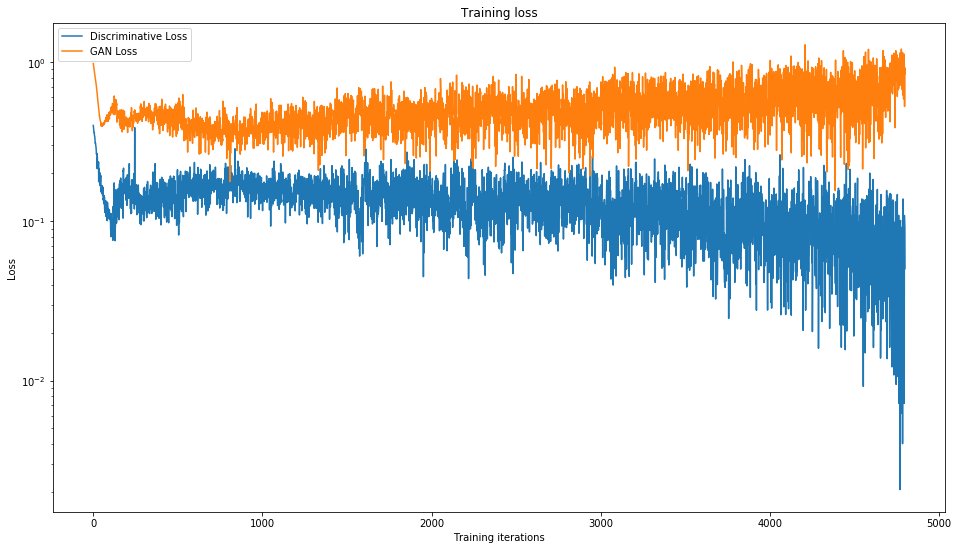

In [21]:
# Plot GAN losses
ax = pd.DataFrame(
    {
        'GAN Loss': gan_loss,
        'Discriminative Loss': discrimator_loss,
    }
).plot(title='Training loss', figsize=(16, 9), logy=True)
ax.set_xlabel("Training iterations")
ax.set_ylabel("Loss")

In [22]:
# Run model against test set
predictions = gan.predict(X_test).squeeze()

In [23]:
# Get the prediction metrics of the model
print("The Mean Absolute Error: %.5f" % metrics.mean_absolute_error(y_test, predictions))  
print("The Median Absolute Error: %.5f" % metrics.median_absolute_error(y_test, predictions)) 
print("The Mean Squared Error: %.5f" % metrics.mean_squared_error(y_test, predictions)) 
print("The Root Mean Squared Error: %.5f" % (np.sqrt(metrics.mean_squared_error(y_test, predictions))))

The Mean Absolute Error: 0.09479
The Median Absolute Error: 0.06749
The Mean Squared Error: 0.01618
The Root Mean Squared Error: 0.12720


In [24]:
# Run Kolmogorov Smirnov test to verify the null hypothesis that the two samples (y_test and predictions) 
# are drawn from the same distribution
value, pValue = ks_2samp(y_test, predictions)

print("Kolmogorov Smirnov Test Statistic =", value, "  ", "pValue = ", pValue)

if pValue > 0.05:
	print('Samples are likely drawn from the same distributions (do not reject H0)')
else:
	print('Samples are likely drawn from different distributions (reject H0)')

Kolmogorov Smirnov Test Statistic = 0.4823529411764706    pValue =  4.2488034759859715e-18
Samples are likely drawn from different distributions (reject H0)


        Generated        Real
count  170.000000  170.000000
mean     0.044546    0.004384
std      0.025265    0.131545
min     -0.009257   -0.326316
25%      0.033220   -0.053946
50%      0.041765    0.005438
75%      0.051551    0.059829
max      0.164916    0.338482


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f858d57ec18>,
      dtype=object)

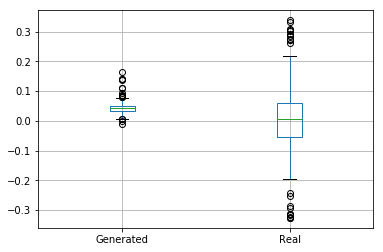

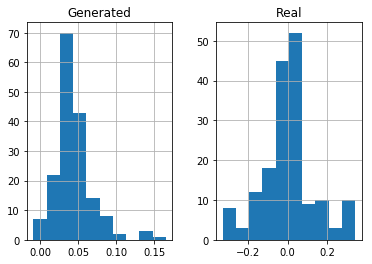

In [25]:
# Get statistics summary over real and generated data
results = pd.DataFrame({'Real':y_test, 'Generated': predictions})
print(results.describe())
results.boxplot()
results.hist(bins=10)

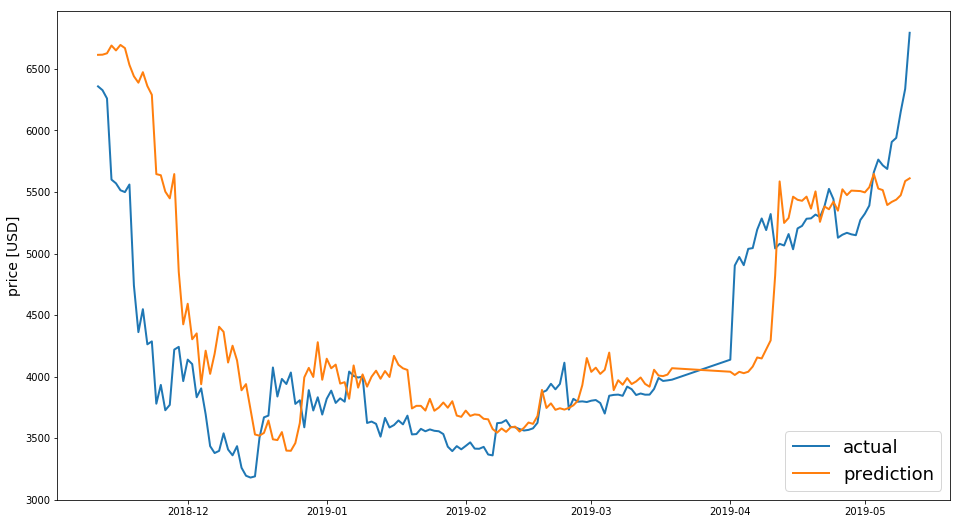

In [27]:
# Plot model predictions against actual data

# 1. Given that the final value is based on rate change, the prediction value is multiplied by the BTC price,
# which is the value previous to the defined TIME_STEPS, thus the future value is based on the formula:
# (CURR_VALUE from -TIME_STEPS days) * PREDICTED_VALUE_DENORMALIZED
# 2. Apply the same value used during the normalization for rate change calculation (df / df.iloc[0] - 1)
prediction_monetary_values = test.Close.values[:-TIME_STEPS] * (predictions + 1)
model_targets = test.Close[TIME_STEPS:]
prediction_series = pd.Series(index=model_targets.index, data=prediction_monetary_values)

line_plot(model_targets, prediction_series, 'actual', 'prediction')

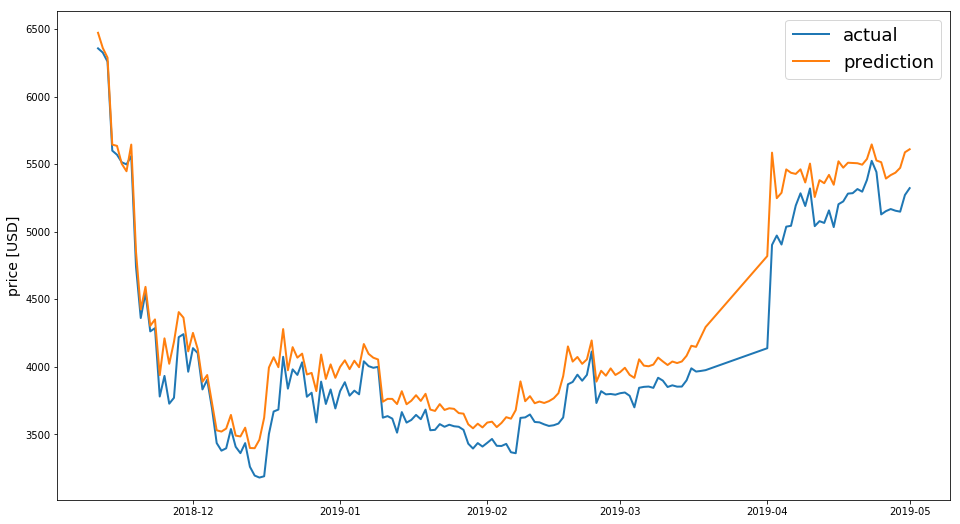

In [32]:
# Apply shift to get graphs aligned
line_plot(model_targets[:][:-TIME_STEPS], prediction_series.shift(-TIME_STEPS), 'actual', 'prediction')

In [33]:
# Save model

In [34]:
# Serialize model to JSON
model_json = gan.to_json()
with open("Model_Files/gan_model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
gan.save_weights("Model_Files/gan_model.h5")
print("Saved model to disk")

Saved model to disk
